In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import numpy as np

def grad_U(Ui, Yij, Vj, reg, eta):
    error = Yij - np.dot(Ui, Vj)
    return eta * (error * Vj - reg * Ui)

def grad_V(Vj, Yij, Ui, reg, eta):
    error = Yij - np.dot(Ui, Vj)
    return eta * (error * Ui - reg * Vj)

def get_err(U, V, Y, reg=0.0):
    mse = 0.0
    for i, j, Yij in Y:
        i, j = int(i) - 1, int(j) - 1
        error = Yij - np.dot(U[i], V[j])
        mse += error**2
    mse /= 2
    reg_term = (reg/2) * (np.linalg.norm(U) ** 2 + np.linalg.norm(V) ** 2)
    return (mse + reg_term) / Y.shape[0]

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    initial_loss = get_err(U, V, Y, reg)
    prev_loss = initial_loss

    for epoch in range(max_epochs):
        np.random.shuffle(Y)
        for i, j, Yij in Y:
            i, j = int(i) - 1, int(j) - 1
            U[i] += grad_U(U[i], Yij, V[j], reg, eta)
            V[j] += grad_V(V[j], Yij, U[i], reg, eta)

        loss = get_err(U, V, Y, reg)
        loss_delta = prev_loss - loss
        if epoch == 0:
            initial_reduction = loss_delta
        elif loss_delta / initial_reduction <= eps:
            print(epoch)
            break
        prev_loss = loss

    return U, V, get_err(U, V, Y, reg=0.0)


In [ ]:
Y_train = pd.read_csv("../data/train.csv").values
Y_test = pd.read_csv("../data/test.csv").values

In [4]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

In [5]:
def train_and_evaluate(params):
    K, eta, reg, train_index, val_index = params
    
    train_set, val_set = Y_train[train_index], Y_train[val_index]

    U, V, e_in = train_model(M, N, 20, eta, reg, train_set)
    
    e_out = get_err(U, V, val_set)
    
    
    return (K, eta, reg, e_in, e_out)

In [6]:
from sklearn.model_selection import KFold
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm

regs = [0.05, 0.1, 0.15, 0.2]
etas = np.geomspace(0.001, 0.1, 5)

kf = KFold(n_splits=5, shuffle=True)

tasks = []
for reg in regs:
    for eta in etas:
        for fold, (train_index, val_index) in enumerate(kf.split(Y_train)):
            tasks.append((20, eta, reg, train_index, val_index))

with Pool(32) as pool:
    results = list(tqdm(pool.imap(train_and_evaluate, tasks), total=len(tasks)))
    pool.close()
    pool.join()
    
E_ins = {}
E_outs = {}

for K, eta, reg, e_in, e_out in results:
    if (eta, reg) not in E_ins:
        E_ins[(eta, reg)] = []
        E_outs[(eta, reg)] = []
    E_ins[(eta, reg)].append(e_in)
    E_outs[(eta, reg)].append(e_out)

E_ins_avg = [(eta, reg, np.mean(E_ins[(eta, reg)])) for eta, reg, in E_ins]
E_outs_avg = [(eta, reg, np.mean(E_outs[(eta, reg)])) for eta, reg, in E_outs]

  0%|          | 0/100 [00:00<?, ?it/s]

7
8
8
10
10
15
19
18
18
23
18
18
47
37
51
42
36
37
16
7
19
43
54
58
5
59
7
16
8
9
11
17
80
15
39
16
7
41
94
15
111
104
7
3
7
49
7
7
4
15
5
5
55
56
120
15
27
26
34
19
35
4
13
5
37
4
167
11
1
3
17
3
3
2
7
9
175
171
176
189
151
106
157
102
154
110
112
114
175
184


100%|██████████| 100/100 [10:26<00:00,  6.27s/it]  


In [20]:
print(etas)

[0.001      0.00316228 0.01       0.03162278 0.1       ]


/tmp/ipykernel_73195/3541705566.py:10: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(f"{z:.3f}", (x, y), textcoords="offset points")


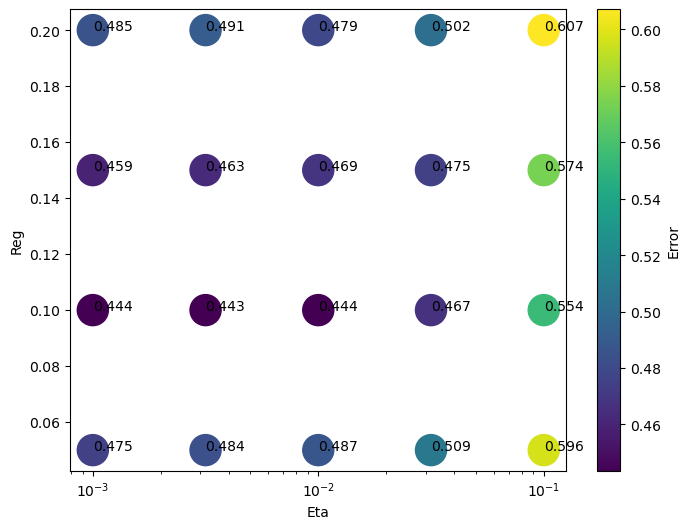

In [ ]:
x_vals, y_vals, z_vals = zip(*E_outs_avg)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_vals, y_vals, c=z_vals, s=500)

cbar = plt.colorbar(scatter)
cbar.set_label('Error')

for x, y, z in zip(x_vals, y_vals, z_vals):
    plt.annotate(f"{z:.3f}", (x, y), textcoords="offset points")

plt.xlabel('Eta')
plt.xscale('log')
plt.ylabel('Reg')

# Show plot
plt.show()

In [22]:
U, V, e_in = train_model(M, N, 20, 0.003, 0.1, Y_train)

84


In [23]:
get_err(U, V, Y_test)

np.float64(0.42729389177895183)

In [ ]:
np.save("../data/naive", V)